In [1]:
from IPython.display import HTML
HTML('''
<style>
.prompt {
  display: none;
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook');
import warnings
warnings.filterwarnings('ignore')
data_538 = pd.read_csv("./data/hate_crimes.csv")
off_by_bias_motivation = pd.read_csv("./data/table_1_incidents_offenses_victims_and_known_offenders_by_bias_motivation_2016.csv")
off_by_off_type = pd.read_csv("./data/table_2_incidents_offenses_victims_and_known_offenders_by_offense_type_2016.csv")
off_race_by_off_type = pd.read_csv("./data/table_3_offenses_known_offenders_race_and_ethnicity_by_offense_type_2016.csv")
off_type_by_bias_motivation = pd.read_csv("./data/table_4_offenses_offense_type_by_bias_motivation_2016.csv")
off_race_by_bias_motivation = pd.read_csv("./data/table_5_offenses_known_offenders_race_and_ethnicity_by_bias_motivation_2016.csv")
off_by_state = pd.read_csv("./data/table_11_offenses_offense_type_by_participating_state_2016.csv")
locations = pd.read_csv("./data/table_10_incidents_bias_motivation_by_location_2016.csv")

[Problem Overview](index.html) | Exploratory Data Analysis | [Modeling Analysis](modeling_analysis.html) | [Conclusion](conclusion.html)
# Exploratory Data Analysis
To perform our analysis, we first created several data visualizations to better understand the data, and to search for trends that could inform our statistical modeling. 

## Comparing hate crime data
We first created some visualization to investigate the similarities and differences between the different measures of hate crimes from our data.

### Southern Poverty Law Center estimates vs FBI estimates

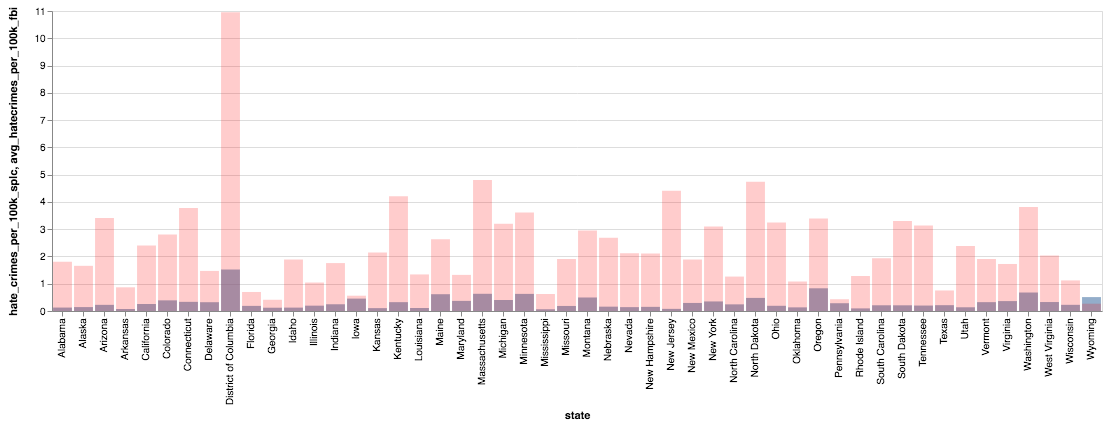

In [3]:
splc = alt.Chart(data_538).mark_bar(opacity = 0.6).encode(x = 'state', y = 'hate_crimes_per_100k_splc:Q')
fbi = alt.Chart(data_538).mark_bar(opacity = 0.2, color = 'red').encode(x = 'state', y = 'avg_hatecrimes_per_100k_fbi:Q')
splc+fbi

This bar chart shows the FBI hate crime estimates in red and the SPLC hate crime estimates in blue, in hate crimes per 100,000 people. As you can see, the FBI estimates are much higher than the SPLC estimates for every state. Additionally, the graph excludes Hawaii since the Hawaii didn't have values for either column in the data. Also of note, the two estimates are closest for Iowa and Pennsylvania.

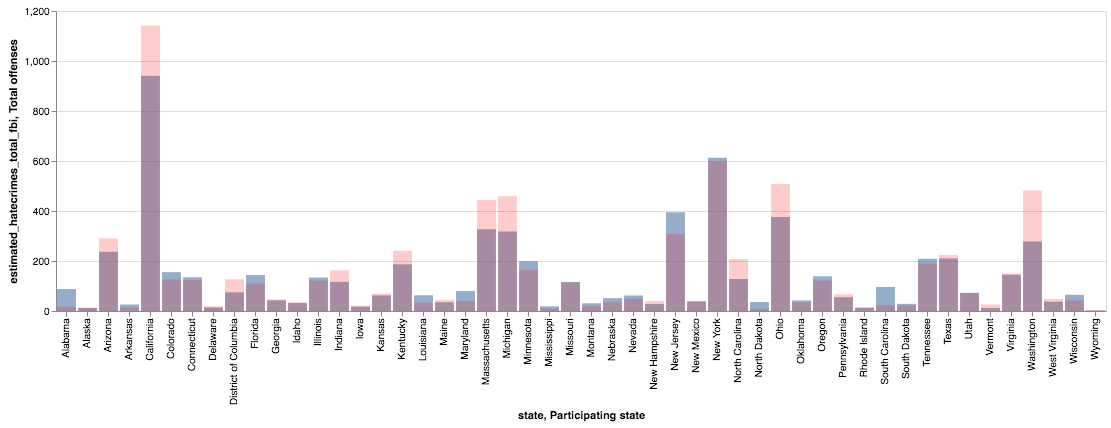

In [4]:
populations = pd.read_csv("./data/estimated_population_2016.csv")

data_538['population_2016'] = populations['population']

data_538['population_2016'] = data_538['population_2016'].astype(float)
data_538['avg_hatecrimes_per_100k_fbi'] = data_538['avg_hatecrimes_per_100k_fbi'].astype(float)

data_538['estimated_hatecrimes_total_fbi'] = (data_538.population_2016 / 100000) * (data_538.avg_hatecrimes_per_100k_fbi)

estimated = alt.Chart(data_538).mark_bar(opacity = 0.6).encode(x = 'state', y = 'estimated_hatecrimes_total_fbi:Q')

offenses = alt.Chart(off_by_state[:50]).mark_bar(opacity = 0.2, color = 'red').encode(x='Participating state', y = 'Total offenses:Q')

estimated + offenses

To further investigate the validity of the data, we compared the value for `Total offenses` from table 11 of the FBI data with a calculated estimate of total hate crimes.  We got this estimate by multiplying the `avg_hatecrimes_per_100k_fbi` column from the fivethirtyeight data by the state's population, divided by 100000.  Logically, we would expect these two values to be very similar, but as the graph shows, they are not for all the states.  Fivethirtyeight didn't explain how they calculated `avg_hatecrimes_per_100k_fbi`, so the discrepancy could be due to their calculations.

## Incidents, offenses, and known offenders by offense type
Table 3 contains data about the number of incidents, offenses, and known offenders by offense type.

### Incidents and offenses

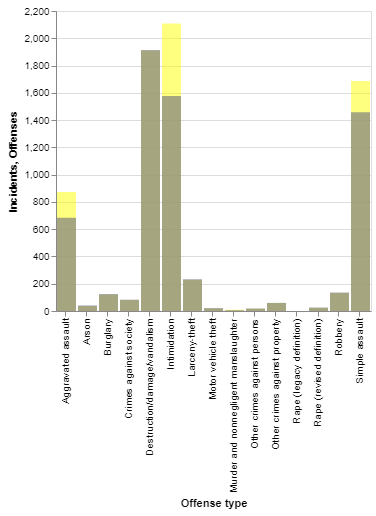

In [5]:


melted = pd.melt(off_by_off_type.iloc[0:17,0:5], var_name='Event Type', id_vars = (['Offense type']))


incidents = alt.Chart(off_by_off_type[:15]).mark_bar(opacity = 0.7, color = 'blue').encode(x = 'Offense type', y = 'Incidents:Q')
offenses = alt.Chart(off_by_off_type[:15]).mark_bar(opacity = 0.5, color = "yellow").encode(x = 'Offense type', y = 'Offenses:Q')

incidents + offenses

This bar chart shows incidents and offenses by offense type, with offenses in yellow and incidents in blue. As the graph shows, for each offense type there were either the same amount of incidents and offenses, or more offenses. The graph also shows that intimidation, destruction/damage/vandalism, and simple assault were by far the most common hate crimes.

## Examining the race/ethnicity of offenders

These pie charts show the breakdown of offenders by race and ethnicity. Note that we again excluded data about events without a known offender.

### Offenses by offender ethnicity

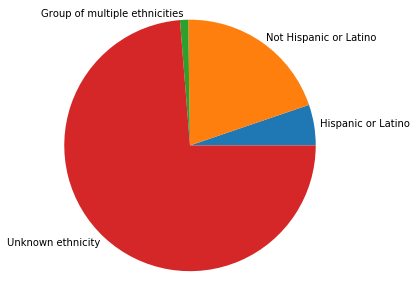

In [6]:
ethnicities = off_race_by_off_type[['Offense type', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Group of multiple ethnicities',
       'Unknown ethnicity']]

races = off_race_by_off_type[['Offense type', 'White', 'Black or African\nAmerican', 'American Indian or Alaska Native', 'Asian', 'Native Hawaiian or Other Pacific Islander', 'Group of multiple races', 'Unknown race']]


hi = ethnicities.T


ho = races.T


plt.figure(figsize=(5, 5))
plt.pie(x=hi[17][1:8].astype(int),startangle=0, labels = hi.index[1:8], labeldistance=1.05);
plt.axis('equal');



The chart shows that the ethnicity of the majority of the offenders was unknown. Of offenders with known ethnicity, the majority are Not Hispanic or Latino.

### Offenses by offender race

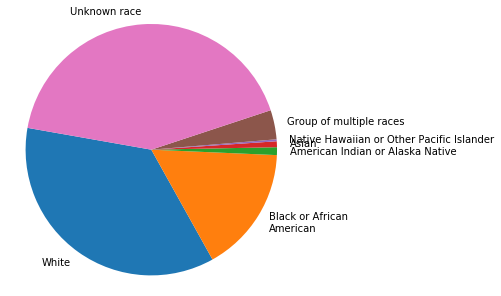

In [7]:
plt.figure(figsize=(5, 5))
plt.pie(x=ho[17][1:8].astype(int),startangle=170, labels = ho.index[1:8], labeldistance=1.1);
plt.axis('equal');

The pie chart shows that the race was unknown of nearly a third of the offenders. Additionally, white offenders made up another third. Black or African American offenders were the next largest group of offenders.

This chart shows the offense type by bias motivation category. (For a more in depth look at the offense type by specific bias motivations, [view the datatables](datatables.html)).  The graph shows that the majority of offenses of all types are motivated by race/ethnicity/ancestry bias.  Religion bias and sexual orientation bias are also strong motivators.  Looking more closely at the top offenses, religion affects destruction/damage/vandalism more than it affects intimidation and simple assault. Religion isn't as strong as a bias motivation for assaults, both simple and aggravated, compared to destruction/damage/vandalism and intimidation.

## Examining Bias Motivation
We next looked at bias motivation and its relationship with other variables. First, we examined the relationship between offender race/ethnicity and bias motivation, with data provided from Table 3.  Note that in the following two graphs, we excluded data from offenses with an unknown offender.

### Offense type by bias motivation

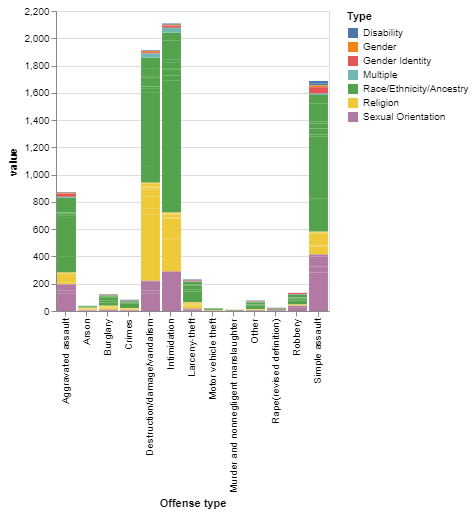

In [8]:
melted4 = pd.melt(off_type_by_bias_motivation[:35].drop('Total', axis = 1), var_name='Offense type', id_vars = (['Bias motivation', 'Type']))


alt.Chart(melted4).mark_bar().encode(
x='Offense type',
y= 'value',
color='Type')

### Offender race by bias motivation

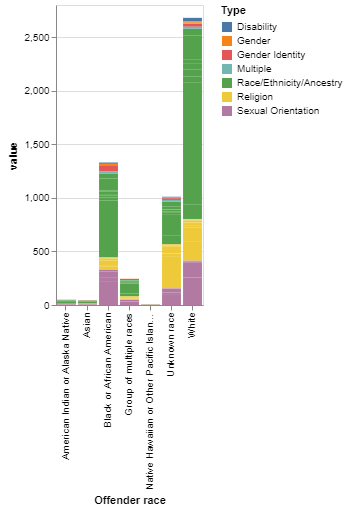

In [9]:
clipped = pd.read_csv("./data/table5_without_totals.csv")
melted2 = pd.melt(clipped[['Bias motivation', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian', 'Native Hawaiian or Other Pacific Islander', 'Group of multiple races', 'Unknown race', 'Type']], var_name = 'Offender race', id_vars = ['Bias motivation', 'Type'])
alt.Chart(melted2).mark_bar().encode(
x='Offender race',
y= 'value',
color='Type')


This chart shows the breakdown of bias motivation category by offender race. The chart shows that white people are by far the largest category of offenders, and that they are primarily motivated by race/ethnicity/ancestry bias.

### Offender ethnicity by bias motivation

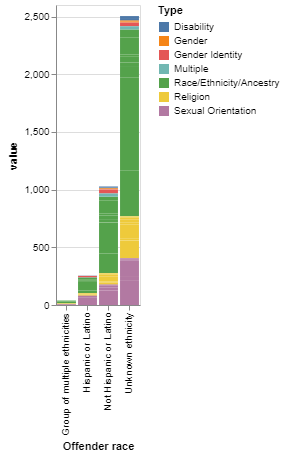

In [10]:
clipped = pd.read_csv("./data/table5_without_totals.csv")
melted_e = pd.melt(clipped[['Bias motivation', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Group of multiple ethnicities',
       'Unknown ethnicity', 'Type']], var_name = 'Offender race', id_vars = ['Bias motivation', 'Type'])
alt.Chart(melted_e).mark_bar().encode(
x='Offender race',
y= 'value',
color='Type')


As the graph shows, the ethnicity of most of the offenders were unknown.  Of the offender with known ethnicity, a majority of them were not Hispanic or Latino. This graph shows the previously established trend of race/ethnicity/ancestry bias being the strongest motivator.

### Incidents and offenses by bias motivation

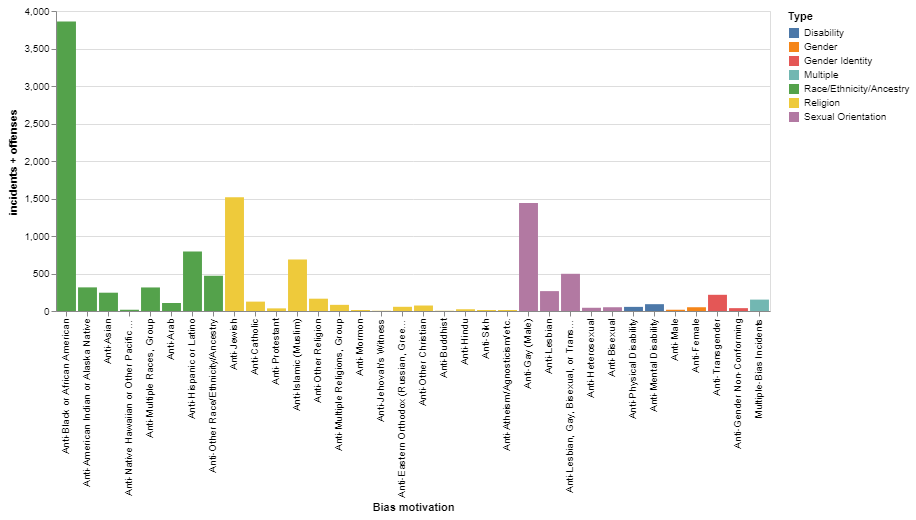

In [11]:
off_by_bias = off_by_bias_motivation.iloc[1:35,::]

off_by_bias['incidents + offenses'] = off_by_bias['Incidents'] + off_by_bias['Offenses']

incidents = alt.Chart(off_by_bias).mark_bar().encode(
    alt.X('Bias motivation', sort = ['Anti-Black or African American',
       'Anti-American Indian or Alaska Native', 'Anti-Asian',
       'Anti-Native Hawaiian or Other Pacific Islander',
       'Anti-Multiple Races, Group', 'Anti-Arab',
       'Anti-Hispanic or Latino', 'Anti-Other Race/Ethnicity/Ancestry',
       'Anti-Jewish', 'Anti-Catholic', 'Anti-Protestant',
       'Anti-Islamic (Muslim)', 'Anti-Other Religion',
       'Anti-Multiple Religions, Group', 'Anti-Mormon',
       "Anti-Jehovah's Witness",
       'Anti-Eastern Orthodox (Russian, Greek, Other)',
       'Anti-Other Christian', 'Anti-Buddhist', 'Anti-Hindu', 'Anti-Sikh',
       'Anti-Atheism/Agnosticism/etc.', 'Anti-Gay (Male)', 'Anti-Lesbian',
       'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)',
       'Anti-Heterosexual', 'Anti-Bisexual', 'Anti-Physical Disability',
       'Anti-Mental Disability', 'Anti-Male', 'Anti-Female',
       'Anti-Transgender', 'Anti-Gender Non-Conforming',
       'Multiple-Bias Incidents']),
    alt.Y('incidents + offenses'),
    color='Type',
)
incidents




The first chart aims to look at the frequency of hate incidents for each bias motivation. The bars are colored by their bias motivation categories: Disability, Gender, Gender Identity, Multiple Bias Motivations, Race/Ethnicity/Ancestry, Religion, and Sexual Orientation.

From this chart, it is immediately clear that Anti-Black or African American motivated incidents have the highest frequency at around 3900. This is double the frequencies of both Anti-Jewish and Anti-Gay (Male) motivated incidents, the next most frequent bias motivations.

[Previous FBI results](https://www.nbcnews.com/news/nbcblk/every-tally-hate-crimes-blacks-are-most-frequent-victims-n938541) paint a similar picture, with African Americans being targeted more than any other minority group, a fact that is in line with what we know about the treatment of black people in the United States, from slavery to the current political climate where white nationalism has become mainstream.

Notably, the biases that motivated the least hate incidents are Anti-Native Hawaiian, Anti-Mormon, Anti-Jehovah's Witness, Anti-Buddhist and Anti-Male. It's important to note that although Anti-Native Hawaiian motivated hate crimes rank low via this chart, the original FBI data does not include hate crime data from Hawaii, as it is the one state which does not take part in the annual report. It would be interesting and potentially enlightening for future studies to consult data on Hawaii's hate crimes, for there is much left uncovered.

### Incidents and offenses by bias motivation, in pie form.

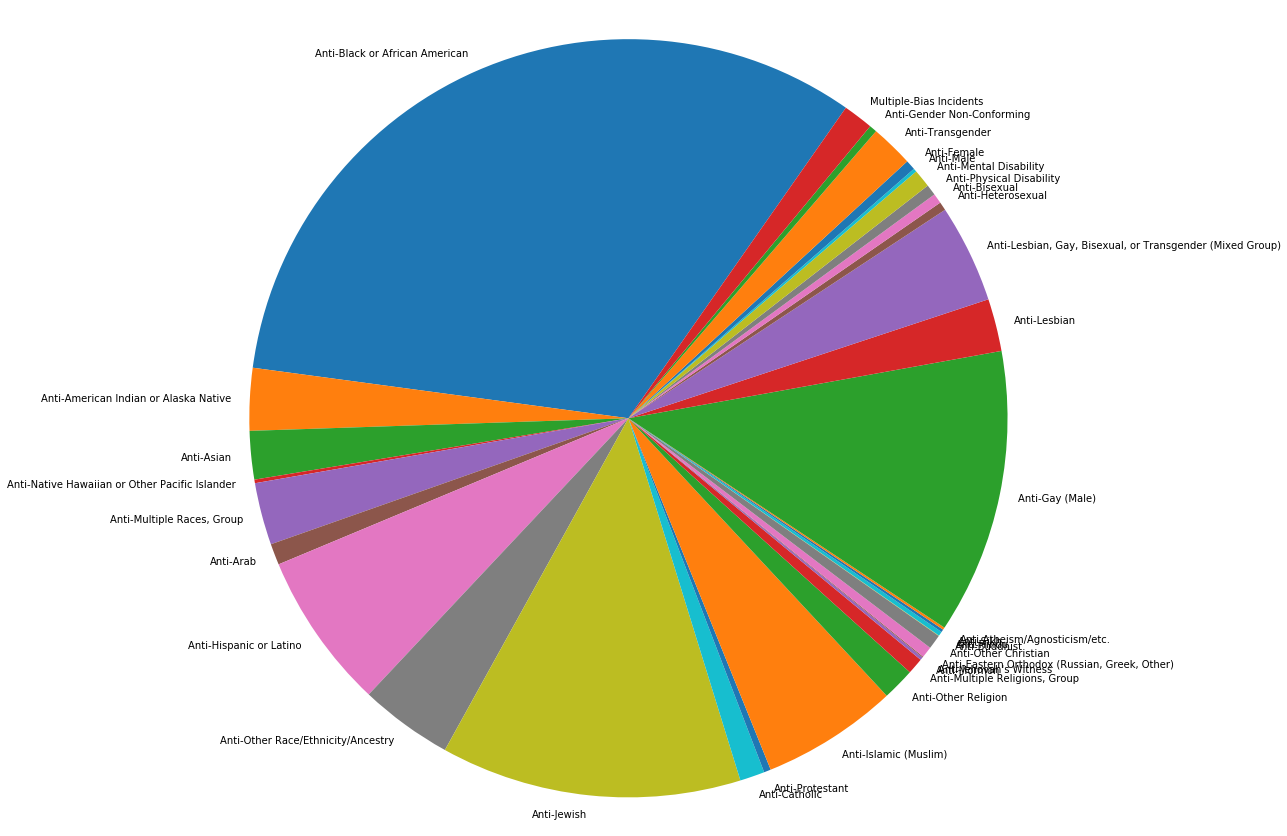

In [12]:
plt.figure(figsize=(15, 15))
plt.pie(x=off_by_bias['incidents + offenses'],startangle=55, labels = off_by_bias['Bias motivation'], labeldistance=1.05);
plt.axis('equal');

The pie chart is a different visualization of the same data as detailed above. The pie chart shows more clearly that anti-Black or African American hate crimes made up about a third of all hate crimes.

## Examining relationships between demographic data and hate crime rates

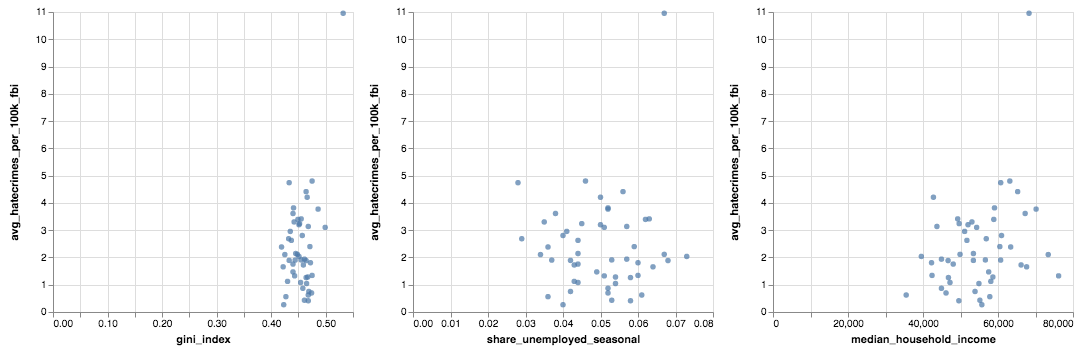

In [13]:
alt.Chart(data_538).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=300,
    height=300
).repeat(
    row=['avg_hatecrimes_per_100k_fbi'],
    column=['gini_index',
       'share_unemployed_seasonal',
       'median_household_income']
)


These first three graphs show a slight positive correlation between `avg_hatecrimes_per_100k_fbi` and `gini_index`, as well as `median_household_income`.

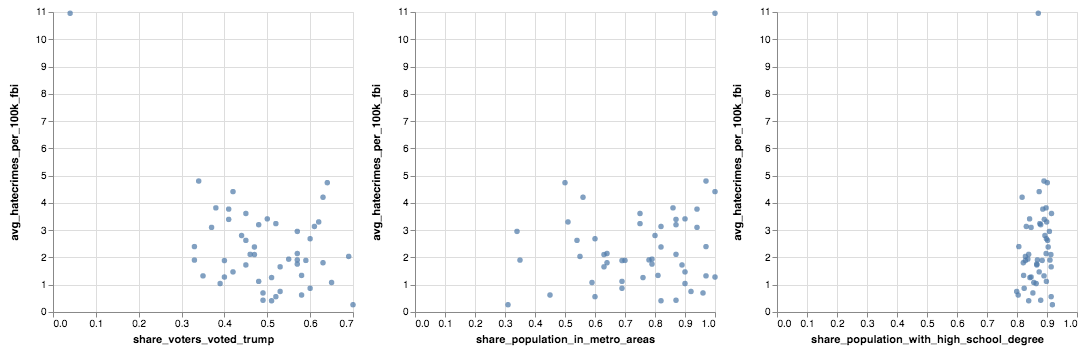

In [14]:
alt.Chart(data_538).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=300,
    height=300
).repeat(
    row=['avg_hatecrimes_per_100k_fbi'],
    column=['share_voters_voted_trump',
       'share_population_in_metro_areas',
       'share_population_with_high_school_degree']
)

In the three plots above, the share population in metro areas shows a slight positive correlation with hate crimes and the share voters who voted for Trump shows a slight negative correlation, meaning in areas where the majority of voters voted for Trump in the 2016 presidential election showed fewer average hate crimes. Washington DC, the major outlier with the most hate crimes, actually had the least amount of votes for Trump (less than 10% of the population) as compared to the rest of country's states whose votes for Trump are between 30% and 70%. This may imply that areas where Trump support is low, where Trump supporters are in the minority as compared to minorities such as African Americans (only 6% of whom voted for Trump), result in higher hate crimes.

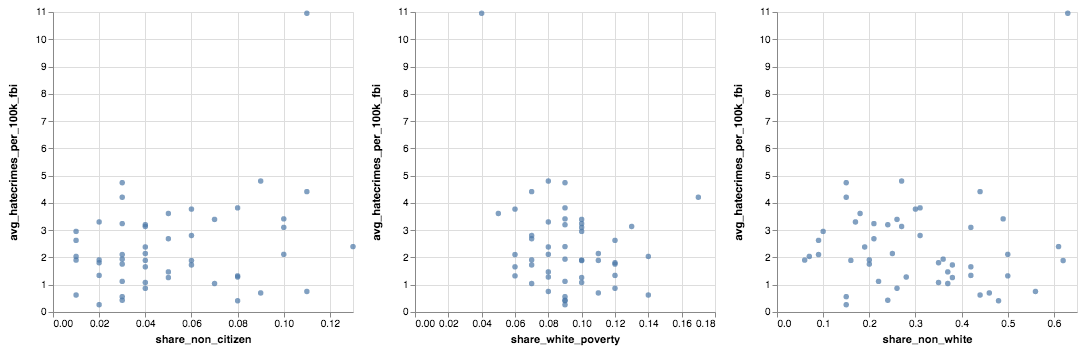

In [11]:
alt.Chart(data_538).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=300,
    height=300
).repeat(
    row=['avg_hatecrimes_per_100k_fbi'],
    column=['share_non_citizen',
       'share_white_poverty', 'share_non_white']
)


The final three graphs don't seem to show a correlation between hate crimes and share of population that's not a citizen, the share of white people below the poverty line, or the share of non white people.

What is clear from all of these scatterplots is that there is one point that is a clear outlier, Washington, D.C.  Washington D.C. has over 11 `avg_hatecrimes_per_100k_fbi`, while all of the states are under 5.  We're not exactly sure why this is, but we think it may be due to the fact that Washington, D.C. has a low population, as well as only one police department.  That means that the data for all of Washington, D.C. is dependent on that single police department.  


## Breakdown of hate crimes by state

### Average hate crimes per 100k people

In [16]:
import plotly.plotly as py
import pandas as pd
import plotly

plotly.tools.set_credentials_file(username='caseyahlan', api_key='0WpK0XNGz71YCokMFYqB')

for col in data_538.columns:
    data_538[col] = data_538[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data_538['text'] = data_538['state'] + '<br>' +\
    'Average per 100k people: '+data_538['avg_hatecrimes_per_100k_fbi']

data = [ dict(
        type='choropleth',
        colorscale =  scl,
        autocolorscale = False,
        locations = data_538['code'],
        z = data_538['avg_hatecrimes_per_100k_fbi'].astype(float),
        locationmode = 'USA-states',
        text = data_538['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Hate Crimes per 100k"
        )
    ) ]

layout = dict(
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

py.iplot( fig, filename='fbi' )

This map graph shows the `avg_hatecrimes_per_100k_fbi` from the fivethirtyeight data. It shows some variability in hate crimes per 100k, with North Dakota, Massachusetts, and Kentucky appearing particularly dark. If you scroll in, you'll see that Washington, D.C. has the highest number of average hate crimes per 100k. The chart below shows the same data, in bar form.

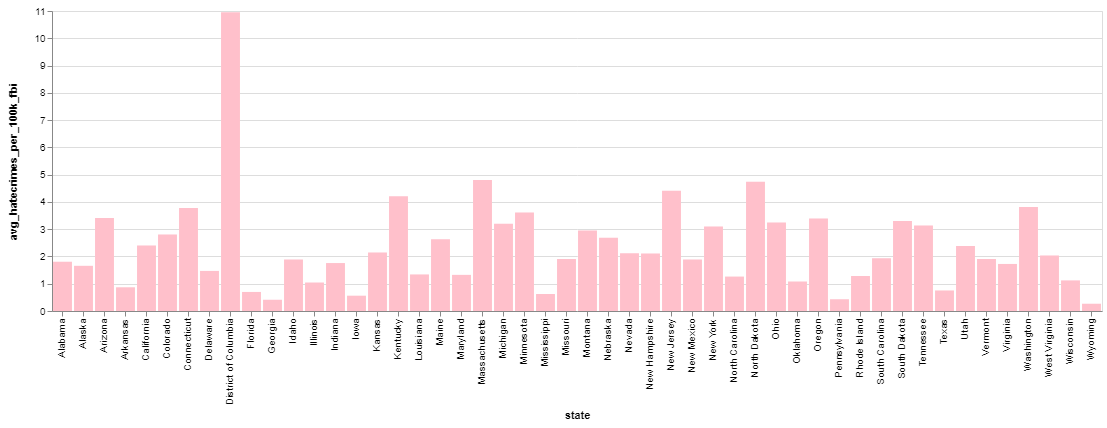

In [17]:
per_100k = alt.Chart(data_538).mark_bar(color = 'pink').encode(x='state', y = 'avg_hatecrimes_per_100k_fbi:Q')
per_100k

### Total offenses by state

In [18]:
plotly.tools.set_credentials_file(username='caseyahlan', api_key='0WpK0XNGz71YCokMFYqB')

for col in off_by_state.columns:
    off_by_state[col] = off_by_state[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

off_by_state['text'] = off_by_state['Participating state'] + '<br>' +\
    'total offenses: '+ off_by_state['Total offenses']

data = [ dict(
        type='choropleth',
        colorscale =  scl,
        autocolorscale = False,
        locations = off_by_state['code'][:51],
        z = off_by_state['Total offenses'][:51].astype(float),
        locationmode = 'USA-states',
        text = off_by_state['text'][:51],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Hate Crimes in 2016"
        )
    ) ]

layout = dict(
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

py.iplot( fig, filename='total offenses' )

This map shows the total offenses per state, from the FBI data. This map shows much less variation in color, with California and New York showing up as darker on the map.  This is likely explained by those states' high populations. This map shows that the states had fairly similar total hate crimes in 2016, even if the rates were more varied. The chart below shows the same data in bar form.

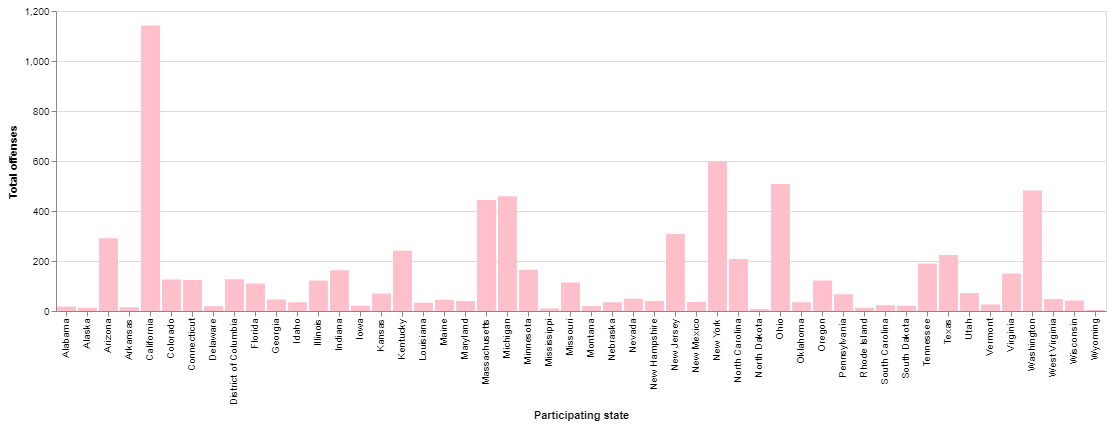

In [19]:
alt.Chart(off_by_state[:50]).mark_bar(color = 'pink').encode(x='Participating state', y = 'Total offenses:Q')


### [Continue to Modeling Analysis](modeling_analysis.html)